In [1]:
import torch

#using GPU
# See how many devices are around
# torch.cuda.device_count()
# Set it to a particular device
torch.cuda.set_device(0)
# Check which device you are on
torch.cuda.current_device()


0

In [2]:
torch.no_grad()

In [3]:
from fastai.vision import *
import pandas as pd
import numpy as np
train = pd.read_csv('/home/cqiuac/EfficientNet-PyTorch-master/semi_data/tran_anno.csv', header=None)

path = '/home/cqiuac/EfficientNet-PyTorch-master/semi_data/'
bs = 8
np.random.seed(42)
src = (ImageList.from_folder(path+'train').split_by_rand_pct(0.1).label_from_folder())
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=360,
                      max_zoom=1.3,
                      p_affine=0.5
                      )


data = (src.transform(tfms, size=224, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs).normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (27000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,bad_1,bad_1,bad_1,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,good_0,good_0,good_0,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Test: None

In [4]:
#b3 model

from efficientnet_pytorch import EfficientNet
# from efficientnet_pytorch.utils import Conv2dSamePadding
model = EfficientNet.from_name('efficientnet-b3')
model_name = 'efficientnet-b3'
image_size = EfficientNet.get_image_size(model_name)
model = EfficientNet.from_pretrained(model_name)



newmodel = model
newmodel.add_module('_fc',nn.Linear(1536, 2))
loss_func = nn.CrossEntropyLoss()
# RMSprop = partial(torch.optim.RMSprop)

from ranger import Ranger

import torch
from torch.optim import Optimizer

learn1 = Learner(data, newmodel, loss_func=loss_func, metrics=[accuracy], opt_func=Ranger,model_dir='/home/cqiuac/EfficientNet-PyTorch-master/models')


learn1.split([[learn1.model._conv_stem, learn1.model._bn0, learn1.model._blocks[:12]],
             [learn1.model._blocks[12:],learn1.model._conv_head], 
             [learn1.model._bn1,learn1.model._fc]])

learn1.load('/home/cqiuac/EfficientNet-PyTorch-master/models/b3_0_unfreeze_0.978')

Loaded pretrained weights for efficientnet-b3
set state called


Learner(data=ImageDataBunch;

Train: LabelList (27000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,bad_1,bad_1,bad_1,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,good_0,good_0,good_0,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], grou

In [5]:
np.random.seed(42)
path='/home/cqiuac/EfficientNet-PyTorch-master/semi_data/'
test_data = ImageList.from_folder('/home/cqiuac/EfficientNet-PyTorch-master/semi_data/test/all_tests')
data.add_test(test_data)
print(data)


ImageDataBunch;

Train: LabelList (27000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,bad_1,bad_1,bad_1,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,good_0,good_0,good_0,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Test: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train


In [6]:
#b3 valid
predictions, *_ = learn1.get_preds(DatasetType.Valid)
n = predictions.numpy()
df1= pd.DataFrame(n)
df1.columns=['b3_0','b3_1']
# df1.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/01101607_unfreeze.csv',index=False)

name=data.test_ds.x.items
name=list(name)
name=[str(x).split('/')[-1][:-4] for x in name ]


label=data.valid_ds.y.items
label=list(label)

label_new=[]
for x in label:
    if x ==0:
        label_new.append('bad_1')
    else:
        label_new.append('good_0')

label_new = [x[-1:] for x in label_new]

# df1['file_name']=name
df1['label']=label_new

# df1.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/df1.csv',index=False)
df1

,b3_0,b3_1,label
0,0.998913,0.001087,1
1,0.000403,0.999597,0
2,0.000039,0.999961,0
3,0.000470,0.999530,0
4,0.989169,0.010831,1
...,...,...,...
2995,0.000034,0.999966,0
2996,0.000080,0.999920,0
2997,0.000023,0.999977,0
2998,0.998823,0.001177,1


In [7]:
# b3 test
predictions, *_ = learn1.get_preds(DatasetType.Test)
n = predictions.numpy()
df1_test= pd.DataFrame(n)
df1_test.columns=['b3_0','b3_1']
# df1.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/01101607_unfreeze.csv',index=False)

name=data.test_ds.x.items
name=list(name)
name=[str(x).split('/')[-1][:-4] for x in name ]


df1_test['file_name']=name



# df1_test.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/df1_test.csv',index=False)
# print(len(name))
# print(len(df1))
df1_test

,b3_0,b3_1,file_name
0,0.995061,0.004939,e429bd9e3ae17c5116fbb16f72adbe90
1,0.000168,0.999832,111dbf672ab4bae9908f6f7411bc4edc
2,0.000016,0.999984,16e45ba0e8df6da5435b3e0471202d28
3,0.000117,0.999883,0202f51e23faca1ca4b834cd54de05e1
4,0.995585,0.004415,1e3b65dee7744ed89e61b5fb023ec742
...,...,...,...
2995,0.000014,0.999986,e1962b6efbc199ccdbe8d2f678eae51a
2996,0.000055,0.999945,b4e09a8d9613b6e495b92df005c41eec
2997,0.000008,0.999992,bcd69af63dc2bfcf39e67bd5c50d3dfa
2998,0.000035,0.999965,e9b4fea1acd43ae4a042e9fc6dd875be


In [8]:
#b5 model
from fastai.vision import *
from efficientnet_pytorch import EfficientNet
# from efficientnet_pytorch.utils import Conv2dSamePadding
model = EfficientNet.from_name('efficientnet-b5')
model_name = 'efficientnet-b5'
image_size = EfficientNet.get_image_size(model_name)
model = EfficientNet.from_pretrained(model_name)



newmodel = model
newmodel.add_module('_fc',nn.Linear(2048, 2))
loss_func = nn.CrossEntropyLoss()
# RMSprop = partial(torch.optim.RMSprop)

from ranger import Ranger

import torch
from torch.optim import Optimizer

learn = Learner(data, newmodel, loss_func=loss_func, metrics=[accuracy], opt_func=Ranger,model_dir='/home/cqiuac/EfficientNet-PyTorch-master/models')


learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:12]],
             [learn.model._blocks[12:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])

learn2 = learn
learn2.load('/home/cqiuac/EfficientNet-PyTorch-master/models/b5_5_unfreeze_0.975')

Loaded pretrained weights for efficientnet-b5
set state called


Learner(data=ImageDataBunch;

Train: LabelList (27000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,bad_1,bad_1,bad_1,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,good_0,good_0,good_0,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Test: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momen

In [9]:
#b5 valid
predictions, *_ = learn2.get_preds(DatasetType.Valid)
n = predictions.numpy()
df2= pd.DataFrame(n)
df2.columns=['b5_0','b5_1']
# df1.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/01101607_unfreeze.csv',index=False)

name=data.valid_ds.x.items
name=list(name)

name=[str(x).split('/')[-1][:-4] for x in name ]




label=data.valid_ds.y.items
label=list(label)

label_new=[]
for x in label:
    if x ==0:
        label_new.append('bad_1')
    else:
        label_new.append('good_0')

label_new = [x[-1:] for x in label_new]

# df2['file_name']=name
# df2['label']=label_new

# df2.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/df2.csv',index=False)
df2

,b5_0,b5_1
0,0.997245,0.002755
1,0.023350,0.976650
2,0.004754,0.995246
3,0.009238,0.990762
4,0.995028,0.004972
...,...,...
2995,0.007770,0.992230
2996,0.009655,0.990345
2997,0.023878,0.976122
2998,0.995560,0.004440


In [10]:
#b5 test
predictions, *_ = learn2.get_preds(DatasetType.Test)
n = predictions.numpy()
df2_test= pd.DataFrame(n)
df2_test.columns=['b5_0','b5_1']
# df1.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/01101607_unfreeze.csv',index=False)

name=data.valid_ds.x.items
name=list(name)
name=[str(x).split('/')[-1][:-4] for x in name ]

# df1['file_name']=name
# df1['label']=label_new

# df2_test.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/df2_test.csv',index=False)
df2_test

,b5_0,b5_1
0,0.991133,0.008867
1,0.004877,0.995123
2,0.003870,0.996130
3,0.102889,0.897111
4,0.992379,0.007621
...,...,...
2995,0.004669,0.995331
2996,0.009054,0.990946
2997,0.018436,0.981564
2998,0.017473,0.982527


In [11]:
#resnet34
learn3=cnn_learner(data,models.resnet34,metrics=[accuracy],model_dir='/home/cqiuac/EfficientNet-PyTorch-master/models')
learn3.load('/home/cqiuac/EfficientNet-PyTorch-master/models/resnet34_36_unfreeze_0.968')


Learner(data=ImageDataBunch;

Train: LabelList (27000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,bad_1,bad_1,bad_1,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,good_0,good_0,good_0,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Test: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inp

In [12]:
#resnet34 valid
predictions, *_ = learn3.get_preds(DatasetType.Valid)
n = predictions.numpy()
df3= pd.DataFrame(n)
df3.columns=['resnet34_0','resnet34_1']
# df1.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/01101607_unfreeze.csv',index=False)

name=data.valid_ds.x.items
name=list(name)

name=[str(x).split('/')[-1][:-4] for x in name ]




label=data.valid_ds.y.items
label=list(label)

label_new=[]
for x in label:
    if x ==0:
        label_new.append('bad_1')
    else:
        label_new.append('good_0')

label_new = [x[-1:] for x in label_new]

# df3['file_name']=name
# df3['label']=label_new

# df3.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/df3.csv',index=False)
df3

,resnet34_0,resnet34_1
0,0.911674,0.088326
1,0.002469,0.997531
2,0.003191,0.996809
3,0.003873,0.996127
4,0.809519,0.190481
...,...,...
2995,0.003761,0.996239
2996,0.001514,0.998486
2997,0.000614,0.999386
2998,0.875922,0.124078


In [13]:
#resnet34 test
predictions, *_ = learn3.get_preds(DatasetType.Test)
n = predictions.numpy()
df3_test= pd.DataFrame(n)
df3_test.columns=['resnet34_0','resnet34_1']
# df1.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/01101607_unfreeze.csv',index=False)

name=data.test_ds.x.items
name=list(name)
name=[str(x).split('/')[-1][:-4] for x in name ]


# df3_test['file_name']=name
# df1['label']=label_new

# df3_test.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/df3_test.csv',index=False)
df3_test

,resnet34_0,resnet34_1
0,0.775112,0.224888
1,0.005798,0.994202
2,0.009577,0.990423
3,0.004451,0.995549
4,0.880804,0.119196
...,...,...
2995,0.002263,0.997737
2996,0.002985,0.997015
2997,0.002364,0.997636
2998,0.000941,0.999059


In [14]:
#resnet50
learn4=cnn_learner(data,models.resnet50,metrics=[accuracy],model_dir='/home/cqiuac/EfficientNet-PyTorch-master/models')
learn4.load('/home/cqiuac/EfficientNet-PyTorch-master/models/resnet50_9_unfreeze_0.959')


Learner(data=ImageDataBunch;

Train: LabelList (27000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,bad_1,bad_1,bad_1,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,good_0,good_0,good_0,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Test: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inp

In [15]:
#resnet50 valid
predictions, *_ = learn4.get_preds(DatasetType.Valid)
n = predictions.numpy()
df4= pd.DataFrame(n)
df4.columns=['resnet50_0','resnet50_1']
# df1.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/01101607_unfreeze.csv',index=False)

name=data.valid_ds.x.items
name=list(name)

name=[str(x).split('/')[-1][:-4] for x in name ]




label=data.valid_ds.y.items
label=list(label)

label_new=[]
for x in label:
    if x ==0:
        label_new.append('bad_1')
    else:
        label_new.append('good_0')

label_new = [x[-1:] for x in label_new]

# df4['file_name']=name
# df4['label']=label_new

# df4.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/df4.csv',index=False)
df4

,resnet50_0,resnet50_1
0,0.920121,0.079879
1,0.005733,0.994267
2,0.004371,0.995629
3,0.003953,0.996047
4,0.790142,0.209858
...,...,...
2995,0.004222,0.995778
2996,0.003194,0.996806
2997,0.006139,0.993861
2998,0.871382,0.128618


In [17]:
#resnet50 test
predictions, *_ = learn4.get_preds(DatasetType.Test)
n = predictions.numpy()
df4_test= pd.DataFrame(n)
df4_test.columns=['resnet50_0','resnet50_1']
# df1.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/01101607_unfreeze.csv',index=False)

name=data.valid_ds.x.items
name=list(name)
name=[str(x).split('/')[-1][:-4] for x in name ]



# df1['file_name']=name
# df1['label']=label_new

# df4_test.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/df4_test.csv',index=False)
df4_test

,resnet50_0,resnet50_1
0,0.903193,0.096807
1,0.002390,0.997610
2,0.000865,0.999135
3,0.005915,0.994085
4,0.835689,0.164311
...,...,...
2995,0.006367,0.993633
2996,0.003010,0.996990
2997,0.001218,0.998782
2998,0.007547,0.992454


In [18]:
#resnet101
learn5=cnn_learner(data,models.resnet101,metrics=[accuracy],model_dir='/home/cqiuac/EfficientNet-PyTorch-master/models')
learn5.load('/home/cqiuac/EfficientNet-PyTorch-master/models/resnet101_5_unfreeze_0.974')


Learner(data=ImageDataBunch;

Train: LabelList (27000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,bad_1,bad_1,bad_1,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bad_1,good_0,good_0,good_0,bad_1
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train;

Test: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/cqiuac/EfficientNet-PyTorch-master/semi_data/train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inp

In [19]:
#resnet101 valid
predictions, *_ = learn5.get_preds(DatasetType.Valid)
n = predictions.numpy()
df5= pd.DataFrame(n)
df5.columns=['resnet101_0','resnet101_1']
# df1.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/01101607_unfreeze.csv',index=False)

name=data.valid_ds.x.items
name=list(name)

name=[str(x).split('/')[-1][:-4] for x in name ]




label=data.valid_ds.y.items
label=list(label)

label_new=[]
for x in label:
    if x ==0:
        label_new.append('bad_1')
    else:
        label_new.append('good_0')

label_new = [x[-1:] for x in label_new]

# df5['file_name']=name
# df5['label']=label_new

# df5.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/df5.csv',index=False)
df5

,resnet101_0,resnet101_1
0,0.911610,0.088390
1,0.004338,0.995662
2,0.000310,0.999690
3,0.002433,0.997567
4,0.939728,0.060272
...,...,...
2995,0.000107,0.999893
2996,0.010358,0.989642
2997,0.022271,0.977729
2998,0.852538,0.147462


In [20]:
#resnet101 test
predictions, *_ = learn5.get_preds(DatasetType.Test)
n = predictions.numpy()
df5_test= pd.DataFrame(n)
df5_test.columns=['resnet101_0','resnet101_1']
# df1.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/01101607_unfreeze.csv',index=False)

name=data.valid_ds.x.items
name=list(name)
name=[str(x).split('/')[-1][:-4] for x in name ]


# df1['file_name']=name
# df1['label']=label_new

# df5_test.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/df5_test.csv',index=False)
df5_test

,resnet101_0,resnet101_1
0,0.705127,0.294873
1,0.008074,0.991926
2,0.000121,0.999879
3,0.011365,0.988635
4,0.838728,0.161272
...,...,...
2995,0.001262,0.998738
2996,0.000932,0.999068
2997,0.001930,0.998070
2998,0.021145,0.978855


In [21]:
df=pd.concat([df1,df2,df3,df4,df5],axis=1)
# df.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/models/pred/two_stac.csv')
df

,b3_0,b3_1,label,b5_0,b5_1,resnet34_0,resnet34_1,resnet50_0,resnet50_1,resnet101_0,resnet101_1
0,0.998913,0.001087,1,0.997245,0.002755,0.911674,0.088326,0.920121,0.079879,0.911610,0.088390
1,0.000403,0.999597,0,0.023350,0.976650,0.002469,0.997531,0.005733,0.994267,0.004338,0.995662
2,0.000039,0.999961,0,0.004754,0.995246,0.003191,0.996809,0.004371,0.995629,0.000310,0.999690
3,0.000470,0.999530,0,0.009238,0.990762,0.003873,0.996127,0.003953,0.996047,0.002433,0.997567
4,0.989169,0.010831,1,0.995028,0.004972,0.809519,0.190481,0.790142,0.209858,0.939728,0.060272
...,...,...,...,...,...,...,...,...,...,...,...
2995,0.000034,0.999966,0,0.007770,0.992230,0.003761,0.996239,0.004222,0.995778,0.000107,0.999893
2996,0.000080,0.999920,0,0.009655,0.990345,0.001514,0.998486,0.003194,0.996806,0.010358,0.989642
2997,0.000023,0.999977,0,0.023878,0.976122,0.000614,0.999386,0.006139,0.993861,0.022271,0.977729
2998,0.998823,0.001177,1,0.995560,0.004440,0.875922,0.124078,0.871382,0.128618,0.852538,0.147462


In [23]:
# df_input=df.drop(['file_name'],axis=1)
# # label=df['label']
# df_input
df_input = df

In [25]:
df_test=pd.concat([df1_test,df2_test,df3_test,df4_test,df5_test],axis=1)
df_test_input=df_test.drop(['file_name'],axis=1)
df_test_input

,b3_0,b3_1,b5_0,b5_1,resnet34_0,resnet34_1,resnet50_0,resnet50_1,resnet101_0,resnet101_1
0,0.995061,0.004939,0.991133,0.008867,0.775112,0.224888,0.903193,0.096807,0.705127,0.294873
1,0.000168,0.999832,0.004877,0.995123,0.005798,0.994202,0.002390,0.997610,0.008074,0.991926
2,0.000016,0.999984,0.003870,0.996130,0.009577,0.990423,0.000865,0.999135,0.000121,0.999879
3,0.000117,0.999883,0.102889,0.897111,0.004451,0.995549,0.005915,0.994085,0.011365,0.988635
4,0.995585,0.004415,0.992379,0.007621,0.880804,0.119196,0.835689,0.164311,0.838728,0.161272
...,...,...,...,...,...,...,...,...,...,...
2995,0.000014,0.999986,0.004669,0.995331,0.002263,0.997737,0.006367,0.993633,0.001262,0.998738
2996,0.000055,0.999945,0.009054,0.990946,0.002985,0.997015,0.003010,0.996990,0.000932,0.999068
2997,0.000008,0.999992,0.018436,0.981564,0.002364,0.997636,0.001218,0.998782,0.001930,0.998070
2998,0.000035,0.999965,0.017473,0.982527,0.000941,0.999059,0.007547,0.992454,0.021145,0.978855


In [14]:
class roc(Callback):
    '''
    Updated on March 28 2019 to reflect new change in FastAI's Callback
    ROC_AUC metric callback for fastai. Compute ROC score over each batch and returns the average over batches.
    TO DO: rolling average
    '''
    def __init__(self):
        pass
    
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        # roc_auc_score does not work on batches which does not contain both classes.
        try:
            roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
            self.total += roc_score
            self.batch_count += 1
        except:
            pass
        
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.total/self.batch_count)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


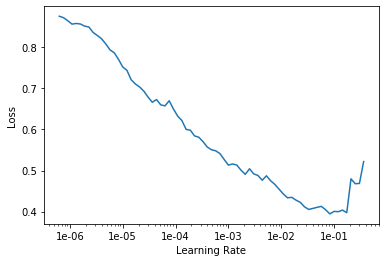

In [26]:
from fastai.tabular import *
from fastai.callbacks import ReduceLROnPlateauCallback, EarlyStoppingCallback, SaveModelCallback
from sklearn.metrics import roc_auc_score
import gc

train=df_input
test=df_test_input
test.label=0


dep_var = 'label'
cont_names = ['b3_0','b3_1','resnet34_0','resnet34_1','resnet50_0','resnet50_1','resnet101_0','resnet101_1']

data = (TabularList.from_df(train, cont_names=cont_names)
            .split_by_rand_pct(seed=47)
            .label_from_df(cols=dep_var)
            .add_test(TabularList.from_df(test, cont_names=cont_names))
            .databunch())

def roc_score(inp, target):
    _, indices = inp.max(1)
    return torch.Tensor([roc_auc_score(target, indices)])[0]

learn = tabular_learner(data, layers=[10000,500], ps=[0.5,0.2], metrics=[accuracy,AUROC()],model_dir='/home/cqiuac/EfficientNet-PyTorch-master/models')

from fastai.callbacks import ReduceLROnPlateauCallback, EarlyStoppingCallback, SaveModelCallback
ES = EarlyStoppingCallback(learn, monitor='roc_score',patience = 5)
RLR = ReduceLROnPlateauCallback(learn, monitor='roc_score',patience = 2)
SAVEML = SaveModelCallback(learn, every='improvement', monitor='roc_score', name='best')



learn.lr_find()
learn.recorder.plot()






In [16]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=10000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=10000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=500, out_features=2, bias=True)
  )
)

In [27]:
from fastai.callbacks import *
callbacks = [
        EarlyStoppingCallback(learn, monitor='roc_score',patience = 5),
        ReduceLROnPlateauCallback(learn, monitor='roc_score',patience = 2),
        SaveModelCallback(learn, every='epoch', monitor='roc_score', name='best')
    ]



In [29]:
learn.fit_one_cycle(50, 1e-3, callbacks = callbacks)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.062938,0.089849,0.975000,0.963681,00:03
1,0.061203,0.083427,0.975000,0.974838,00:03
2,0.066041,0.106069,0.973333,0.945190,00:03
3,0.061172,0.154471,0.975000,0.932797,00:02
4,0.059164,0.119068,0.975000,0.946973,00:02
5,0.059425,0.156047,0.973333,0.927765,00:02
6,0.064050,0.128935,0.971667,0.949504,00:03
7,0.063963,0.093859,0.976667,0.951948,00:03
8,0.065251,0.119564,0.971667,0.947663,00:03
9,0.070585,0.124491,0.975000,0.941308,00:03


In [30]:
learn.load('/home/cqiuac/EfficientNet-PyTorch-master/models/best_11_stacking_0.981')

Learner(data=TabularDataBunch;

Train: LabelList (2400 items)
x: TabularList
b3_0 0.0004; b3_1 0.9996; resnet34_0 0.0025; resnet34_1 0.9975; resnet50_0 0.0057; resnet50_1 0.9943; resnet101_0 0.0043; resnet101_1 0.9957; ,b3_0 0.0000; b3_1 1.0000; resnet34_0 0.0032; resnet34_1 0.9968; resnet50_0 0.0044; resnet50_1 0.9956; resnet101_0 0.0003; resnet101_1 0.9997; ,b3_0 0.0005; b3_1 0.9995; resnet34_0 0.0039; resnet34_1 0.9961; resnet50_0 0.0040; resnet50_1 0.9960; resnet101_0 0.0024; resnet101_1 0.9976; ,b3_0 0.9892; b3_1 0.0108; resnet34_0 0.8095; resnet34_1 0.1905; resnet50_0 0.7901; resnet50_1 0.2099; resnet101_0 0.9397; resnet101_1 0.0603; ,b3_0 0.0000; b3_1 1.0000; resnet34_0 0.0027; resnet34_1 0.9973; resnet50_0 0.0057; resnet50_1 0.9943; resnet101_0 0.0017; resnet101_1 0.9983; 
y: CategoryList
0,0,0,1,0
Path: .;

Valid: LabelList (600 items)
x: TabularList
b3_0 0.0000; b3_1 1.0000; resnet34_0 0.0039; resnet34_1 0.9961; resnet50_0 0.0022; resnet50_1 0.9978; resnet101_0 0.0006; resnet

In [31]:
predictions, *_ = learn.get_preds(DatasetType.Test)
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in predictions]
# labels = np.argmax(predictions, 1)
print(labelled_preds[:5])
label=[x[-1:] for x in labelled_preds]
print(label[:5])
print(len(label))

['1', '0', '0', '0', '1']
['1', '0', '0', '0', '1']
3000


In [32]:
learn.data.test_ds.x.items

array([0, 1, 2, 3, ..., 2996, 2997, 2998, 2999], dtype=object)

In [33]:
# fnames=[f.name.split('/')[-1][:-4] for f in learn.data.test_ds.items]
# fnames = [f.name[:-4] for f in learn.data.test_ds.items]

# fnames=df1['file_name']

# output to a file
submission_df = pd.DataFrame({'id': df1_test['file_name'], 'label': label })
submission_df.to_csv('/home/cqiuac/EfficientNet-PyTorch-master/submission_ensemble_5model_0119.csv', index=False)


In [34]:
submission_df 

,id,label
0,e429bd9e3ae17c5116fbb16f72adbe90,1
1,111dbf672ab4bae9908f6f7411bc4edc,0
2,16e45ba0e8df6da5435b3e0471202d28,0
3,0202f51e23faca1ca4b834cd54de05e1,0
4,1e3b65dee7744ed89e61b5fb023ec742,1
...,...,...
2995,e1962b6efbc199ccdbe8d2f678eae51a,0
2996,b4e09a8d9613b6e495b92df005c41eec,0
2997,bcd69af63dc2bfcf39e67bd5c50d3dfa,0
2998,e9b4fea1acd43ae4a042e9fc6dd875be,0


In [44]:
df1

,b3_0,b3_1,file_name,label
0,0.997506,0.002494,77e75b185fff2ff5f545e53fad14bf8d,1
1,0.015589,0.984411,0fa64de3e3f12beaee51b2c1cf66049d,0
2,0.003483,0.996517,ff2e2eb5aa98b3ba0bc7d13c2dd99ead,0
3,0.004113,0.995887,a60d7e953b44c99d8894229e73ec6529,0
4,0.994672,0.005328,a2764b64150ceabcaa95f891beec23bd,1
...,...,...,...,...
2995,0.006197,0.993803,1b4c8d65185c1fdbad3842127a531346,0
2996,0.003712,0.996288,43c20b6746a8a15a0b80189a401a226b,0
2997,0.021921,0.978079,f6dcdb7a3a1fa9ff96703d2493763b41,0
2998,0.997845,0.002155,63a9d6688984bd6f7c8920986025d770,1
